In [1]:
import pandas as pd
import numpy as np
import math
import torch
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt

In [2]:
base_dir = "Data/"

label2one = {'B':0,'S':1,'X':2}
one2label = {0:'B', 1:'S', 2:'X'}

def normalize(data):
    mu = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return mu, std, (data-mu)/std

vfunc = np.vectorize(lambda x:label2one[x])

input_labels = ['pitcher','batter', 'pitch_type','x0','x','y','ax','ay','az','px','pz','sz_top','sz_bot',
             'vx0','vy0','vz0','pfx_x','z0','start_speed','end_speed',
             'break_y','break_angle','break_length','spin_dir','spin_rate',
             'inning','balls','strikes'
             ]
input_labels = ['pitcher','batter', 'pitch_type','balls', 'strikes','inning','pitch_count']
#input_labels = ['pitcher','batter', 
       #'on_1b', 'on_2b', 'on_3b', 'pitch_type', 'side', 
       #'inning', 'pitch_count', 'balls', 'strikes','offense_score', 'defense_score', 
#       'ay', 'px', 'ax',  
#       'sz_bot', 'vz0', 'vy0', 'pfx_x',
#       'type_confidence', 'z0', 'tfs', 'pz', 'start_speed', 'az', 'zone',
#       'break_angle', 'spin_dir', 'end_speed', 'vx0', 'sz_top', 'nasty',
#       'pfx_z', 'break_y', 'x', 'spin_rate',
#       'y0', 'break_length', 'y', 'x0'
#       ]
feature_length = len(input_labels)-3
print("Feature length:{}".format(feature_length))
train_years = [4,5,6]
dev_years = [7]


train_x = {}
train_y = {}
ctr = 0
for y in train_years:
    filename= base_dir+"MLB_201{0}/MLB_PitchFX_201{0}_RegularSeason.csv".format(str(y))
    print("Loading {}".format(filename))
    f = pd.read_csv(filename)
    
    tmp_x = f[input_labels]
    tmp_y = f['umpcall']

    tmp_x = tmp_x.as_matrix()
    tmp_y = tmp_y.as_matrix()
    tmp_y = vfunc(tmp_y)

    if ctr==0:
        ctr=1
        train_x = tmp_x
        train_y = tmp_y
    else:
        print(train_x.shape)
        print(tmp_x.shape)
        train_x = np.concatenate((train_x, tmp_x), axis=0)
        train_y = np.concatenate((train_y, tmp_y), axis=0)
    
    filename= base_dir+"MLB_201{0}/MLB_PitchFX_201{0}_PostSeason.csv".format(str(y))
    print("Loading {}".format(filename))
    f = pd.read_csv(filename)
    
    tmp_x = f[input_labels]
    tmp_y = f['umpcall']

    tmp_x = tmp_x.as_matrix()
    tmp_y = tmp_y.as_matrix()
    tmp_y = vfunc(tmp_y)
    if ctr==0:
        ctr=1
        train_x = tmp_x
        train_y = tmp_y
    else:
        print(train_x.shape)
        print(tmp_x.shape)
        train_x = np.concatenate((train_x, tmp_x), axis=0)
        train_y = np.concatenate((train_y, tmp_y), axis=0)

filename = base_dir+"MLB_2017/MLB_PitchFX_2017_RegularSeason.csv"
print("Loading test file {}".format(filename))
f2 = pd.read_csv(filename)
test_x = f2[input_labels]
test_y = f2['umpcall']

test_x = test_x.as_matrix()
test_y = test_y.as_matrix()
test_y = vfunc(test_y)

filename = base_dir+"MLB_2017/MLB_PitchFX_2017_PostSeason.csv"
print("Loading test file {}".format(filename))
f2 = pd.read_csv(filename)

tmp_x = f2[input_labels]
tmp_y = f2['umpcall']

tmp_x = tmp_x.as_matrix()
tmp_y = tmp_y.as_matrix()
tmp_y = vfunc(tmp_y)

test_x = np.concatenate((test_x, tmp_x), axis=0)
test_y = np.concatenate((test_y, tmp_y), axis=0)

Feature length:4
Loading Data/MLB_2014/MLB_PitchFX_2014_RegularSeason.csv
Loading Data/MLB_2014/MLB_PitchFX_2014_PostSeason.csv
(658428, 7)
(8837, 7)
Loading Data/MLB_2015/MLB_PitchFX_2015_RegularSeason.csv
(667265, 7)
(672271, 7)
Loading Data/MLB_2015/MLB_PitchFX_2015_PostSeason.csv
(1339536, 7)
(10277, 7)
Loading Data/MLB_2016/MLB_PitchFX_2016_RegularSeason.csv
(1349813, 7)
(703809, 7)
Loading Data/MLB_2016/MLB_PitchFX_2016_PostSeason.csv
(2053622, 7)
(10076, 7)
Loading test file Data/MLB_2017/MLB_PitchFX_2017_RegularSeason.csv
Loading test file Data/MLB_2017/MLB_PitchFX_2017_PostSeason.csv


In [3]:
vv = np.vectorize(lambda x: (isinstance(x, float) and math.isnan(x) ))
idx = ~np.logical_or(vv(train_x[:,0]), vv(train_x[:,1]))
train_x = train_x[idx]
train_y = train_y[idx]

In [4]:
from sklearn.model_selection import train_test_split
train_x, dev_x, train_y, dev_y = train_test_split(train_x, train_y, test_size=0.1, random_state=0, shuffle=True)

In [5]:
train_x[0,:]

array(['conlead01', 'duvalad01', 'FT', 0, 1, 4, 56], dtype=object)

In [6]:
class Lang:
    def __init__(self, name):
        """Init Lang with a name."""
        self.name = name
        self.word2index = {"<UNK>": 0}
        self.word2count = {}
        self.index2word = {0: "<UNK>"}
        self.n_words = 1  # Count SOS and EOS

    def addword(self, word):
        """Add a word to the dict."""
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [7]:
def map2idx(train_x, pl, bl):
    pi = train_x[:,0]
    vfnc = np.vectorize(lambda x: pl.word2index[x] if x in pitch_lang.word2index else 0)
    pi = vfnc(pi).reshape(-1,1)
    vfnc = np.vectorize(lambda x:bl.word2index[x] if x in batter_lang.word2index else 0)
    ba = vfnc(train_x[:,1]).reshape(-1,1)
    
    return np.concatenate((pi,ba,train_x[:,2:]), axis=1)

def data_gen(dx, df, dy, batch_size=100):
    idx = 0
    while True:
        if idx*batch_size >= dx.shape[0]:
            return
        elif (idx+1)*batch_size > dx.shape[0]:
            yield dx[idx*batch_size:,:], df[idx*batch_size:,:], dy[idx*batch_size:]
        else:
            yield dx[idx*batch_size:(idx+1)*batch_size,:], df[idx*batch_size:(idx+1)*batch_size], dy[idx*batch_size:(idx+1)*batch_size]
        idx += 1


def train(train_x, train_f, train_y, dev_x, dev_f, dev_y, model, optimizer, criterion, batch_size=512, max_epoch = 512, validation_interv=1000):
    for ep in range(max_epoch):
        print("Epoch {}".format(ep))
        train_iter = data_gen(train_x, train_f, train_y, batch_size=batch_size)
        ctr = 0
        avg_loss = 0
        for bx,bf,by in train_iter:
            optimizer.zero_grad()
            model.train()
            y_pred = model(bx,bf)
            loss = criterion(y_pred, by)
            loss.backward()
            avg_loss += loss.item()*bx.shape[0]
            optimizer.step()
            ctr+= bx.shape[0]
        #dy_pred = model(dev_x, dev_f)
        model.eval()
        ll = 0
        ctrr = 0
        acc = 0
        for dx,df,dy in data_gen(dev_x, dev_f, dev_y, batch_size=batch_size):
            dy_pred = model(dx, df)
            tmp = criterion(dy_pred, dy).item()
            ll += tmp * dx.shape[0]
            ctrr += dx.shape[0]
            mv, mi = torch.max(dy_pred, 1)
            acc += torch.sum( mi == dy ).item()
        
        print("loss:{} dev_loss:{}, dev_acc:{}".format(avg_loss/ctr, ll/ctrr, acc / ctrr))


In [8]:
pitch_lang = Lang('pitcher')
batter_lang = Lang('batter')
player_lang = Lang('player')
pits = train_x[:,0]
bats = train_x[:,1]
for i in range(len(train_x)):
    pitch_lang.addword(pits[i])
    batter_lang.addword(bats[i])
    player_lang.addword(pits[i])    
    player_lang.addword(bats[i])

In [9]:
vtx = Variable(torch.from_numpy(map2idx(train_x[:,:2], player_lang, player_lang).astype(np.long))).cuda()
vtf = Variable(torch.from_numpy(train_x[:,3:].astype(np.float32))).cuda()
vty = Variable(torch.from_numpy(train_y)).cuda()
vdx = Variable(torch.from_numpy(map2idx(dev_x[:,:2], player_lang, player_lang).astype(np.long))).cuda()
vdf = Variable(torch.from_numpy(dev_x[:,3:].astype(np.float32))).cuda()
vdy = Variable(torch.from_numpy(dev_y)).cuda()

vtestx = Variable(torch.from_numpy(map2idx(test_x[:,:2], player_lang, player_lang).astype(np.long))).cuda()
vtestf = Variable(torch.from_numpy(test_x[:,3:].astype(np.float32))).cuda()
vtesty = Variable(torch.from_numpy(test_y)).cuda()


# Model 1

In [10]:
class Fcc(nn.Module):
    def __init__(self, p=0.1):
        super(Fcc, self).__init__()
        self.drop1 = nn.Dropout(p)
        self.drop2 = nn.Dropout(p)
        self.drop3 = nn.Dropout(p)
        self.drop4 = nn.Dropout(p)
        #self.drop3 = nn.Dropout(p)
        self.lin1 = nn.Linear(feature_length, 300)
        self.act1 = nn.PReLU()
        self.lin2 = nn.Linear(300, 300)
        self.act2 = F.tanh
        self.lin3 = nn.Linear(300, 200)
        self.act3 = F.sigmoid
        self.lin4 = nn.Linear(200, 100)
        self.act4 = nn.SELU()
        self.lin5 = nn.Linear(100, 3)
        #self.lin4 = nn.Linear(100, 3)

    def forward(self, players, features):
        #embedded = self.embedding(players[:,0], players[:,1])
        #output = torch.cat([embedded, features], dim=1)
        #output = self.drop_emb(output)
        output = features
        
        output = self.lin1(output)
        output = self.act1(output)
        output = self.drop1(output)
        
        output = self.lin2(output)
        output = self.act2(output)
        output = self.drop2(output)
        
        output = self.lin3(output)
        output = self.act3(output)
        output = self.drop3(output)
        
        output = self.lin4(output)
        output = self.act4(output)
        output = self.drop4(output)
        
        output = self.lin5(output)
        #output = F.relu(output)
        #output = self.drop3(output)
        
        #output = self.lin4(output)
        
        output = F.log_softmax(output, dim=1)
        return output

In [11]:
model = Fcc(0.1).cuda()
print(model)

Fcc(
  (drop1): Dropout(p=0.1)
  (drop2): Dropout(p=0.1)
  (drop3): Dropout(p=0.1)
  (drop4): Dropout(p=0.1)
  (lin1): Linear(in_features=4, out_features=300, bias=True)
  (act1): PReLU(num_parameters=1)
  (lin2): Linear(in_features=300, out_features=300, bias=True)
  (lin3): Linear(in_features=300, out_features=200, bias=True)
  (lin4): Linear(in_features=200, out_features=100, bias=True)
  (act4): SELU()
  (lin5): Linear(in_features=100, out_features=3, bias=True)
)


In [12]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
#crit = nn.NLLLoss(torch.FloatTensor([0.3,0.3,0.4]).cuda())
crit = nn.NLLLoss()
train(vtx, vtf, vty, vdx, vdf, vdy, model, opt, crit, max_epoch=10, batch_size=4096*64)

Epoch 0
loss:1.0631074991370213 dev_loss:1.0406603813171387, dev_acc:0.4599118088869506
Epoch 1


RuntimeError: cuda runtime error (2) : out of memory at /home/yhhuang/code/tools/pytorch/aten/src/THC/generic/THCStorage.cu:58

In [ ]:
train(vtx, vtf, vty, vdx, vdf, vdy, model, opt, crit, max_epoch=100, batch_size=4096*64)

# Model 2

In [ ]:
class PlayerEmbedding(nn.Module):
    """The class for embedding records.
    This class is for embedding the docvec (r.t, r.e, r.m)
    into a high dimension space.
    Attributes:
        embedding1: embedding for r.t
        embedding2: embedding for r.e
        linear: A linear layer mapping [r.t, r.e, r.m] back to one space
    """

    def __init__(self, pitcher_size, batter_size, embedding_dim):
        super(PlayerEmbedding, self).__init__()
        self.embedding1 = nn.Embedding(pitcher_size, embedding_dim)
        self.embedding2 = nn.Embedding(batter_size, embedding_dim)
        self.embedding_dim = embedding_dim

    def forward(self, p, b):
        emb_p = self.embedding1(p)
        emb_b = self.embedding2(b)

        emb_all = torch.cat([emb_p, emb_b], dim=1)
        return emb_all

    def init_weights(self):
        initrange = 0.1
        em_layer = [self.embedding1, self.embedding2]

        for layer in em_layer:
            layer.weight.data.normal_(0, initrange)

class Fcc(nn.Module):
    def __init__(self, embedding_layer):
        super(Fcc, self).__init__()
        p=0.1
        self.embedding = embedding_layer
        self.drop_emb = nn.Dropout(p)
        self.drop1 = nn.Dropout(p)
        self.drop2 = nn.Dropout(p)
        self.drop3 = nn.Dropout(p)
        self.drop4 = nn.Dropout(p)
        self.lin1 = nn.Linear(2*self.embedding.embedding_dim + feature_length, 300)
        self.act1 = nn.SELU()
        self.lin2 = nn.Linear(300, 300)
        self.act2 = nn.SELU()
        self.lin3 = nn.Linear(300, 300)
        
        self.act3 = nn.SELU()
        self.lin4 = nn.Linear(300, 300)
        self.act4 = nn.SELU()
        self.lin5 = nn.Linear(300, 3)
        #self.lin4 = nn.Linear(100, 3)

    def forward(self, players, features):
        embedded = self.embedding(players[:,0], players[:,1])
        output = torch.cat([embedded, features], dim=1)
        output = self.drop_emb(output)
        
        output = self.lin1(output)
        output = self.act1(output)
        output = self.drop1(output)
        
        output = self.lin2(output)
        output = self.act2(output)
        output = self.drop2(output)
        
        output = self.lin3(output)
        output = self.act3(output)
        output = self.drop3(output)
        
        output = self.lin4(output)
        output = self.act4(output)
        #output = self.drop4(output)
        
        output = self.lin5(output)
        
        output = F.log_softmax(output, dim=1)
        return output

In [ ]:
emb_layer = PlayerEmbedding(pitch_lang.n_words,batter_lang.n_words, 30).cuda()
model = Fcc(emb_layer).cuda()
print(model)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = nn.NLLLoss()
train(vtx, vtf, vty, vdx, vdf, vdy, model, opt, crit, max_epoch=40, batch_size=4096*8)

In [45]:
print(model)
train(vtx, vtf, vty, vdx, vdf, vdy, model, opt, crit, max_epoch=100, batch_size=4096*16)

Fcc(
  (embedding): PlayerEmbedding(
    (embedding1): Embedding(1073, 30)
    (embedding2): Embedding(1409, 30)
  )
  (drop_emb): Dropout(p=0.2)
  (drop1): Dropout(p=0.2)
  (drop2): Dropout(p=0.2)
  (lin1): Linear(in_features=64, out_features=600, bias=True)
  (act1): SELU()
  (lin2): Linear(in_features=600, out_features=200, bias=True)
  (act2): SELU()
  (lin3): Linear(in_features=200, out_features=3, bias=True)
)
Epoch 0
loss:1.0123226479305996 dev_loss:1.0152487630800677, dev_acc:0.47003440422542037
Epoch 1
loss:1.0123535767819545 dev_loss:1.015065942760493, dev_acc:0.4702573048408199
Epoch 2
loss:1.0121118442589532 dev_loss:1.0153059340368993, dev_acc:0.46958375732906915
Epoch 3
loss:1.0121334053785038 dev_loss:1.0154151142709285, dev_acc:0.46973397296118624
Epoch 4
loss:1.0122638532102688 dev_loss:1.0152626026310407, dev_acc:0.47052866211174105
Epoch 5


KeyboardInterrupt: 

In [ ]:
emb_layer = PlayerEmbedding(pitch_lang.n_words,batter_lang.n_words, 500).cuda()
emb_layer.load_state_dict(torch.load('shallow_post.pt.emb'))
model = Fcc(emb_layer).cuda()
model.load_state_dict(torch.load('shallow_post.pt.model'))

In [ ]:
torch.save(model.state_dict(), 'shallow_post.pt.model')
torch.save(emb_layer.state_dict(), 'shallow_post.pt.emb')

In [19]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import pickle
import seaborn as sn
import matplotlib.pyplot as plt

def generate_confusion_matrix(y_test, y_train, file_name = "confusion_matrix.png"):
    ax= plt.subplot()
    cm = confusion_matrix(y_test, y_train)
    df_cm = pd.DataFrame(cm, range(3), range(3))
    sn.set(font_scale=1.2)#for label size
    sn.heatmap(df_cm, annot=True, fmt="d",annot_kws={"size": 14}, cmap="YlGnBu")
#     ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['Ball', 'Strike', 'Hit']) 
    ax.yaxis.set_ticklabels(['Ball', 'Strike', 'Hit'])
    #plt.savefig(file_name)
    plt.show()

### Loss

In [38]:
criter = nn.NLLLoss()
with torch.no_grad():
    ll=0
    ctrr=0
    crit=nn.NLLLoss()
    for dx,df,dy in data_gen(vtestx, vtestf, vtesty, batch_size=128):
        model.eval()
        dy_pred = model(dx, df)
        tmp = criter(dy_pred, dy).data[0]
        ll += tmp * dx.shape[0]
        ctrr += dx.shape[0]
    dev_loss = ll.item()/ctrr

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if __name__ == '__main__':


### Accuracy

In [39]:
with torch.no_grad():
    ll=0
    ctrr=0
    pred = []
    for dx,df,dy in data_gen(vtestx, vtestf, vtesty, batch_size=128):
        model.eval()
        dy_pred = model(dx, df)
        _,py = torch.max(dy_pred, 1)
        ll += torch.sum(py==dy)
        pred.append(py.cpu().data)
        ctrr += dx.shape[0]
    dev_acc = ll.item()/ctrr

In [40]:
pred_y = torch.cat(pred).numpy()

Fcc(
  (embedding): PlayerEmbedding(
    (embedding1): Embedding(1073, 30)
    (embedding2): Embedding(1409, 30)
  )
  (drop_emb): Dropout(p=0.2)
  (drop1): Dropout(p=0.2)
  (drop2): Dropout(p=0.2)
  (lin1): Linear(in_features=64, out_features=600, bias=True)
  (act1): SELU()
  (lin2): Linear(in_features=600, out_features=200, bias=True)
  (act2): SELU()
  (lin3): Linear(in_features=200, out_features=3, bias=True)
)
test loss: 1.0139234410259232 dev_los: 0.4691603830700644


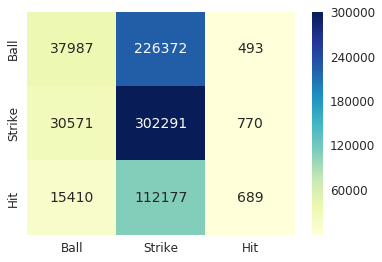

In [42]:
print(model)
print("test loss: {} dev_los: {}".format(dev_loss, dev_acc))
generate_confusion_matrix(test_y, pred_y)

# DeepModel

----------

In [ ]:
class PlayerStat:
    def __init__(self, train_x):
        self.types = list(set(train_x[:,2]))
        self.pitchers = list(set(train_x[:,0]))
        self.batters = list(set(train_x[:,1]))
        self.type_dist = {}
        self.type_sum = {}
        self.feat_dim = train_x.shape[1]-3
        for i in range(train_x.shape[0]):
            p = train_x[i,0]
            b = train_x[i,1]
            t = train_x[i,2]
            self.addWord(p+' '+b, t, train_x[i,3:])
            self.addWord(p, t, train_x[i,3:])
            self.addWord(b, t, train_x[i,3:])
            self.addWord('<TOTAL>', t, train_x[i,3:])
    def addWord(self, label, t, data):
        if label not in self.type_dist:
            self.type_dist[label] = {}
            self.type_sum[label] = {}
            for tt in self.types:
                self.type_dist[label][tt]=0
                self.type_sum[label][tt] = np.zeros((1,self.feat_dim))
        self.type_dist[label][t] +=1
        self.type_sum[label][t] += data.astype(np.float32)

In [ ]:
ps = PlayerStat(train_x)

In [ ]:
def predictd(self, X, model):
    model.eval()
    pred_y = np.zeros((X.shape[0], 3))
    for i in range(X.shape[0]):
        p = str(X[i,0])
        b = str(X[i,1])
        inp_mat = np.zeros((len(self.types), self.feat_dim))
        if p+' '+b in self.type_dist:
            for j in range(len(self.types)):
                tp = self.types[j]
                inp_mat[j,:] = self.type_sum[p+' '+b][tp] / self.type_dist[p+' '+b][tp]
                inp_mat[j, -3:] = X[i, -3:]
            vx = Variable(torch.from_numpy(map2idx(np.asarray([[p,b]]*len(self.types))).astype(np.long))).cuda()
            vf = Variable(torch.from_numpy( inp_mat.astype(np.float32) )).cuda()
            pp = model(vx,vf)
            pp = pp.exp().cpu().data.numpy()
            ctr = 0
            for j in range(len(self.types)):
                pred_y[i,:]+=pp[j,:] * self.type_dist[p+' '+b][self.types[j]]
                ctr += self.type_dist[p+' '+b][self.types[j]]
            pred_y[i,:] /= ctr
        elif p in self.type_dist:
            for j in range(len(self.types)):
                tp = self.types[j]
                inp_mat[j,:] = self.type_sum[p][tp] / self.type_dist[p][tp]
                inp_mat[j, -3:] = X[i, -3:]
                
            vx = Variable(torch.from_numpy(map2idx(np.asarray([[p,'<UNK>']]*len(self.types))).astype(np.long))).cuda()
            vf = Variable(torch.from_numpy( inp_mat.astype(np.float32) )).cuda()
            pp = model(vx,vf)
            pp = pp.exp().cpu().data.numpy()

            ctr = 0
            for j in range(len(self.types)):
                pred_y[i,:]+=pp[j,:] * self.type_dist[p][self.types[j]]
                ctr += self.type_dist[p][self.types[j]]
            pred_y[i,:] /= ctr

        elif b in self.type_dist:
            for j in range(len(self.types)):
                tp = self.types[j]
                inp_mat[j,:] = self.type_sum[b][tp] / self.type_dist[b][tp]
                inp_mat[j, -3:] = X[i, -3:]
                
            vx = Variable(torch.from_numpy(map2idx(np.asarray([['<UNK>',b]]*len(self.types))).astype(np.long))).cuda()
            vf = Variable(torch.from_numpy( inp_mat.astype(np.float32) )).cuda()
            pp = model(vx,vf)
            pp = pp.exp().cpu().data.numpy()

            ctr = 0
            for j in range(len(self.types)):
                pred_y[i,:]+=pp[j,:] * self.type_dist[b][self.types[j]]
                ctr += self.type_dist[b][self.types[j]]
            pred_y[i,:] /= ctr
        else:
            for j in range(len(self.types)):
                tp = self.types[j]
                inp_mat[j,:] = self.type_sum['<TOTAL>'][tp] / self.type_dist['<TOTAL>'][tp]
                inp_mat[j, -3:] = X[i, -3:]
                
            vx = Variable(torch.from_numpy(map2idx(np.asarray([['<UNK>','<UNK>']]*len(self.types))).astype(np.long))).cuda()
            vf = Variable(torch.from_numpy( inp_mat.astype(np.float32) )).cuda()
            pp = model(vx,vf)
            pp = pp.exp().cpu().data.numpy()

            ctr = 0
            for j in range(len(self.types)):
                pred_y[i,:]+=pp[j,:] * self.type_dist['<TOTAL>'][self.types[j]]
                ctr += self.type_dist['<TOTAL>'][self.types[j]]
            pred_y[i,:] /= ctr
    return pred_y

In [ ]:
pred = predictd(ps, test_x, model)

In [ ]:
np.sum(np.argmax(pred, axis=1) == test_y) / test_y.shape[0]

In [ ]:
def criterion(pred, y):
    s = 0;
    for i in range(pred.shape[0]):
        s -= np.log(pred[i,y[i]])
    return s/y.shape[0]

In [ ]:
criterion(pred, test_y)

In [ ]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(test_y, pred_y) / test_y.shape[0]
print(cf)
plt.matshow(cf, vmin=0, vmax=1)
plt.colorbar()
plt.show()

# Model 2

In [ ]:
class PlayerEmbedding(nn.Module):
    def __init__(self, pitcher_size, batter_size, embedding_dim):
        super(PlayerEmbedding, self).__init__()
        self.embedding1 = nn.Embedding(pitcher_size, embedding_dim)
        self.embedding2 = nn.Embedding(batter_size, embedding_dim)
        self.out_dim = embedding_dim*16
        self.conv1 = nn.Conv1d(2,32,1, padding=0)

        self.conv2 = nn.Conv1d(32,32,1, padding=0)
        self.conv3 = nn.Conv1d(32,32,1, padding=0)
        self.maxpol = nn.MaxPool1d(2)
        self.embedding_dim = embedding_dim

    def forward(self, p, b):
        emb_p = self.embedding1(p)
        emb_b = self.embedding2(b)
        emb_p = emb_p.unsqueeze(1)
        emb_b = emb_b.unsqueeze(1)

        emb_all = torch.cat([emb_p, emb_b], dim=1)
        bypass = F.relu(self.conv1(emb_all))
        
        emb_all = F.relu(self.conv2(bypass))
        emb_all = F.relu(self.conv3(emb_all))
        emb_all += bypass
        emb_all = self.maxpol(emb_all)
        emb_all = emb_all.view(emb_all.shape[0],-1)
        
        return emb_all

    def init_weights(self):
        initrange = 0.5
        em_layer = [self.embedding1, self.embedding2]

        for layer in em_layer:
            #layer.weight.data.normal_(0, initrange)
            layer.weight.data.uniform_(-initrange, initrange)

class ResNet(nn.Module):
    def __init__(self, in_dim):
        super(ResNet, self).__init__()

        self.lin1 = nn.Linear(in_dim, in_dim)
        self.lin2 = nn.Linear(in_dim, in_dim)
    def forward(self, x):
        output = F.relu(self.lin1(x))
        return self.lin2(output) + x
class Fcc(nn.Module):
    def __init__(self, embedding_layer):
        super(Fcc, self).__init__()

        self.embedding = embedding_layer
        #hid_dim = [100,100,100,100,100]
        p = 0.0
        res_dim=1024
        expand_fea_dim = 64

        self.bn = torch.nn.BatchNorm1d(feature_length)
        #self.drop1 = nn.Dropout(p)
        #self.lin1 = nn.Linear(2*self.embedding.embedding_dim + 22, hid_dim[0])

        self.fea1 = nn.Linear(feature_length,64)
        #self.feadrop1 = nn.Dropout(p)
        self.feares2 = ResNet(64)
        #self.feadrop2 = nn.Dropout(p)
        self.fea3 = nn.Linear(64,expand_fea_dim)

        self.lin1 = nn.Linear(self.embedding.out_dim + expand_fea_dim, res_dim)
        #self.lin1 = nn.Linear(2*self.embedding.embedding_dim, hid_dim[0])
        #self.drop2 = nn.Dropout(p)
        self.res2 = ResNet(res_dim)
        #self.drop3 = nn.Dropout(p)
        self.res3 = ResNet(res_dim)
        #self.drop4 = nn.Dropout(p)

        self.lin3 = nn.Linear(res_dim, 256)

        self.res4 = ResNet(256)
        #self.drop5 = nn.Dropout(p)
        self.res5 = ResNet(256)
        #self.drop6 = nn.Dropout(p)
        #self.lin6 = nn.Linear(256, 64)
        #self.lin7 = nn.Linear(64,64)
        self.lin8 = nn.Linear(256,3)
    
    def forward(self, players, features):
        embedded = F.relu(self.embedding(players[:,0], players[:,1]))
        fea = self.bn(features)
        fea = F.relu(self.fea1(fea))
        #fea = self.feadrop1(fea)
        fea = F.relu(self.feares2(fea))
        #fea = self.feadrop2(fea)
        fea = F.relu(self.fea3(fea))
        output = torch.cat([embedded, fea], dim=1)
        #output = embedded

        #output = self.drop1(output)
        output = self.lin1(output)
        output = F.relu(output)
        
        #output = self.drop2(output)
        output = self.res2(output)
        output = F.relu(output)
        
        #output = self.drop3(output)
        output = self.res3(output)
        output = F.relu(output)
        
        output = F.relu(self.lin3(output))

        #output = self.drop4(output)
        output = self.res4(output)
        output = F.relu(output)

        #output = self.drop5(output)
        output = self.res5(output)
        output = F.relu(output)

        #output = self.lin6(output)
        #output = F.relu(output)
        #output = self.lin7(output)
        #output = F.relu(output)

        output = self.lin8(output)
        output = F.log_softmax(output, dim=1)

        return output

In [ ]:
emb_layer = PlayerEmbedding(pitch_lang.n_words,batter_lang.n_words, 100).cuda()
model = Fcc(emb_layer).cuda()
print(model)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = nn.NLLLoss()
train(vtx, vtf, vty, vdx, vdf, vdy, model, opt, crit, max_epoch=5, batch_size=2048, validation_interv=500)

In [ ]:
train(vtx, vtf, vty, vdx, vdf, vdy, model, opt, crit, max_epoch=5, batch_size=2048, validation_interv=500)

In [ ]:
emb_layer_15 = PlayerEmbedding(pitch_lang.n_words,batter_lang.n_words, 100).cuda()
emb_layer_15.load_state_dict(emb_layer.state_dict())
model_15 = Fcc(emb_layer_15).cuda()
model_15.load_state_dict(model.state_dict())

In [ ]:
model_15.eval()
ctrr=0
ll=0
for dx,df,dy in data_gen(vtestx, vtestf, vtesty, batch_size=128):
    dy_pred = model_15(dx, df)
    pred_y = dy_pred.cpu().data.numpy()
    tmp = np.sum(np.argmax(pred_y,axis=1) == dy.cpu().data.numpy()) / dx.shape[0]
    ll += tmp * dx.shape[0]
    ctrr += dx.shape[0]

In [ ]:
ll / ctrr

In [ ]:
model_15.eval()
ctrr=0
ll=0
for dx,df,dy in data_gen(vtestx, vtestf, vtesty, batch_size=128):
    dy_pred = model_15(dx, df)
    tmp = crit(dy_pred, dy).data[0]
    ll += tmp * dx.shape[0]
    ctrr += dx.shape[0]
ll/ctrr

In [ ]:
pred = []
for dx,df,dy in data_gen(vtestx, vtestf, vtesty, batch_size=128):
    dy_pred = model_15(dx, df)
    pred_y = dy_pred.cpu().data.numpy()
    pred.append(np.argmax(pred_y, axis=1))

In [ ]:
pred_l = pred[0]
for i in range(1,len(pred)):
    pred_l = np.concatenate((pred_l, pred[i]))

In [ ]:
confusion_matrix(test_y, pred_l)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
pred = predictd(ps, test_x, model_15)

In [ ]:
np.sum(np.argmax(pred, axis=1) == test_y) / test_y.shape[0]

In [ ]:
criterion(pred, test_y)

In [ ]:
confusion_matrix(test_y, np.argmax(pred, axis=1))

# Model 3

Learn only from previous available data

In [ ]:
emb_layer = PlayerEmbedding(pitch_lang.n_words,batter_lang.n_words, 100).cuda()
model2 = Fcc(emb_layer).cuda()
print(model2)
opt = torch.optim.Adam(model2.parameters(), lr=1e-3)
crit = nn.NLLLoss()
train(vtx, vtf, vty, vdx, vdf, vdy, model2, opt, crit, max_epoch=5, batch_size=2048, validation_interv=500)

In [ ]:
train(vtx, vtf, vty, vdx, vdf, vdy, model2, opt, crit, max_epoch=5, batch_size=2048, validation_interv=500)

In [ ]:
emb_layer_5 = PlayerEmbedding(pitch_lang.n_words,batter_lang.n_words, 100).cuda()
emb_layer_5.load_state_dict(emb_layer.state_dict())
model_5 = Fcc(emb_layer_5).cuda()
model_5.load_state_dict(model2.state_dict())

In [ ]:
model_5.eval()
ctrr=0
ll=0
for dx,df,dy in data_gen(vtestx, vtestf, vtesty, batch_size=128):
    dy_pred = model_5(dx, df)
    pred_y = dy_pred.cpu().data.numpy()
    tmp = np.sum(np.argmax(pred_y,axis=1) == dy.cpu().data.numpy()) / dx.shape[0]
    ll += tmp * dx.shape[0]
    ctrr += dx.shape[0]

In [ ]:
ll / ctrr

In [ ]:
model_5.eval()
ctrr=0
ll=0
for dx,df,dy in data_gen(vtestx, vtestf, vtesty, batch_size=128):
    dy_pred = model_5(dx, df)
    tmp = crit(dy_pred, dy).data[0]
    ll += tmp * dx.shape[0]
    ctrr += dx.shape[0]

In [ ]:
ll/ctrr

In [ ]:
from sklearn.metrics import confusion_matrix
model_5.eval()
ctrr=0
ll=np.zeros((3,3))
for dx,df,dy in data_gen(vtestx, vtestf, vtesty, batch_size=128):
    dy_pred = model_5(dx, df)
    pred_y = np.argmax(dy_pred.cpu().data.numpy(), axis=1)
    tmp = confusion_matrix(pred_y, dy.cpu().data.numpy())
    ll += tmp

In [ ]:
ll

# Baseline codes

In [ ]:
np.sum(1 == test_y) / test_y.shape[0]

In [ ]:
dum_pred = np.zeros((test_y.shape[0],3))
pad = 3.333333333333333333e-1
dum_pred[:, 1] = 1 - 2*pad
dum_pred[:,0] = pad
dum_pred[:,2] = pad
criterion(dum_pred, test_y)

In [ ]:
confusion_matrix(test_y, np.argmax(dum_pred, axis=1))

# Result
Here are some of the result on the dataset

training: 2015,2016,2017 regular season

dev: 0.1 of the training set

test: 2017 post season

## Baseline
We can simply predict the output to be all 1 as the 'S' is the most outcome in our training data. The accuracy of this simple prediction function is:

The accuracy on the test set is: 0.47999643589058183

The cross-entropy on the test set is: 1.0986122886679723

The confusion matrix is:
```text
array([[   0, 4009,    0],
       [   0, 5387,    0],
       [   0, 1827,    0]])
```

The cross-entropy of this model is actually affected by the probability assigned to the other two classes(class 0 and 2). The minimum cross-entropy is: 1.0986122886679723

# Shallow NN w/ Post + Avg. Gen.
In this model, we first train our shallow Net with data including the post pitch features. And use a generative model to make the prediction.

We use all of the following features as our input:
``` text
'pitcher','batter', 'pitch_type','x0','x','y','ax','ay','az','px','pz','sz_top','sz_bot',
 'vx0','vy0','vz0','pfx_x','z0','start_speed','end_speed',
 'break_y','break_angle','break_length','spin_dir','spin_rate',
 'inning','balls','strikes'```

This is the structure of the shallow NN:
```text
Fcc(
  (embedding): PlayerEmbedding(
    (embedding1): Embedding(1120, 100)
    (embedding2): Embedding(1445, 100)
  )
  (drop1): Dropout(p=0.1)
  (lin1): Linear(in_features=225, out_features=100, bias=True)
  (lin2): Linear(in_features=100, out_features=100, bias=True)
  (lin3): Linear(in_features=100, out_features=50, bias=True)
  (lin4): Linear(in_features=50, out_features=3, bias=True)
)```
After 30 epoch of training:

The accuracy on the test set is: 0.7106440969731745

The cross-entropy on the test set is: 0.6153840772368059

The confusion matrix is:
```text
array([[3276,  721,   12],
       [ 658, 4446,  283],
       [  92, 1446,  289]])
```

One observation is that the 'X'(2) classes is likely to be predicted as 'S'(1). This coincide to our knowledge of the baseball.

## The Generation Model
Since we do not have most of the pitch/fx features. We average the feature from the training data grouped by pitcher,batter and pitch_type

The accuracy on the test set is: 0.450325224984407

The cross-entropy on the test set is: 1.7214855619830554

The confusion matrix is:
```text
array([[  99, 3454,  456],
       [ 124, 4656,  607],
       [  30, 1498,  299]])
```

From the confusion matrix, we can see that most of the prediction is 'S'. This might be dut to we are averaging dataset to generate input and most entries in the dataset are 'S'.

# Shallow NN w/o Post Features
We use the same structure as the previous model but with only the input features:
```text
'pitcher','batter','balls', 'strikes','inning','pitch_count'
```

The accuracy on the test set is: 0.47042509443886577

The cross-entropy on the test set is: 0.9997494564191931

The confusion matrix is:
```text
array([[ 928, 3066,   15],
       [ 866, 4489,   32],
       [ 326, 1485,   16]])
```

# Deep Model w/ Post + Avg. Gen
We follow the same procedure in the shallow model.

We use all of the following features as our input:
``` text
'pitcher','batter', 'pitch_type','x0','x','y','ax','ay','az','px','pz','sz_top','sz_bot',
 'vx0','vy0','vz0','pfx_x','z0','start_speed','end_speed',
 'break_y','break_angle','break_length','spin_dir','spin_rate',
 'inning','balls','strikes'```

```text
Fcc(
  (embedding): PlayerEmbedding(
    (embedding1): Embedding(1120, 100)
    (embedding2): Embedding(1445, 100)
    (conv1): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    (maxpol): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bn): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True)
  (fea1): Linear(in_features=25, out_features=64, bias=True)
  (feares2): ResNet(
    (lin1): Linear(in_features=64, out_features=64, bias=True)
    (lin2): Linear(in_features=64, out_features=64, bias=True)
  )
  (fea3): Linear(in_features=64, out_features=64, bias=True)
  (lin1): Linear(in_features=1664, out_features=1024, bias=True)
  (res2): ResNet(
    (lin1): Linear(in_features=1024, out_features=1024, bias=True)
    (lin2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (res3): ResNet(
    (lin1): Linear(in_features=1024, out_features=1024, bias=True)
    (lin2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (lin3): Linear(in_features=1024, out_features=256, bias=True)
  (res4): ResNet(
    (lin1): Linear(in_features=256, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=256, bias=True)
  )
  (res5): ResNet(
    (lin1): Linear(in_features=256, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=256, bias=True)
  )
  (lin8): Linear(in_features=256, out_features=3, bias=True)
)```

After 10 epoch of training,

The accuracy on the test set is: 0.743473224627996

The cross-entropy on the test set is: 0.6006864595759783

The confusion matrix is:
```text
array([[3404,  598,    7],
       [ 453, 4488,  446],
       [  44, 1331,  452]])
```

## The Generation Model
Since we do not have most of the pitch/fx features. We average the feature from the training data grouped by pitcher,batter and pitch_type

The accuracy on the test set is: 0.4631560188897799 <- 0.450325224984407

The cross-entropy on the test set is: 1.7626901821693999 <- 1.7214855619830554

The confusion matrix is:
```text
array([[ 130, 3624,  255],
       [ 166, 4894,  327],
       [  51, 1602,  174]])
```

# Deep NN w/o Post Features
We use the same structure as the previous model but with only the input features:
```text
'pitcher','batter','balls', 'strikes','inning','pitch_count'
```

After 5 epoch,

The accuracy on the test set is: 0.48730286019780805

The cross-entropy on the test set is: 0.9971903735363663

The confusion matrix is:
```text
array([[ 846, 3163,    0],
       [ 764, 4623,    0],
       [ 290, 1537,    0]])
```

Interesting, the model never predict the outcome as 'X'.